# Alicja Misiuda
# 1.07.2024

In [24]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import time

In [6]:
# Load in sounds
# flute, sr_flute = librosa.load('flute.wav')
# violin, sr_violin = librosa.load('violin.wav')
# print(sr_flute, "sr_flute sampling rate")
# print(sr_violin, "sr_violin sampling rate")
NJ, srNJ = librosa.load('NewJeansOMG.wav', sr=None, mono=True)
print(srNJ, "srNJ sampling rate")

44100 srNJ sampling rate


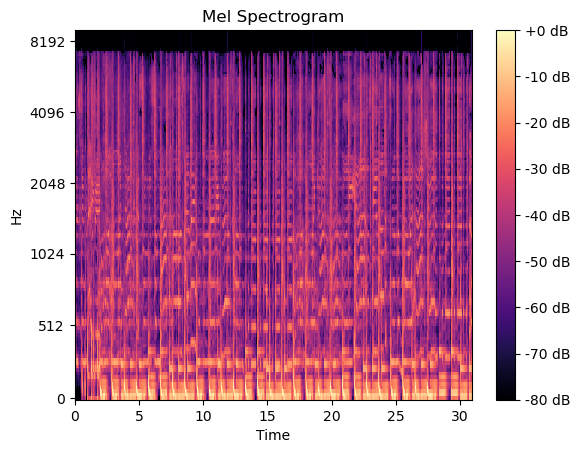

In [16]:
# Create Mel Spectrograms of sounds
# fluteSpec = librosa.feature.melspectrogram(y=flute, sr=sr_flute)
# violinSpec = librosa.feature.melspectrogram(y=violin, sr=sr_violin)
NJSpec = librosa.feature.melspectrogram(y=NJ, sr=srNJ)

# Convert amplitudes to dB
# fluteSpec = librosa.amplitude_to_db(fluteSpec)
# violinSpec = librosa.amplitude_to_db(violinSpec)
#NJSpec = librosa.amplitude_to_db(NJSpec, ref=np.max)
NJSpec = librosa.power_to_db(NJSpec, ref=np.max)

# Plot mel spectrograms
# fig, ax = plt.subplots(1,2, figsize = (30,15))
# ax[0].set(title = 'Mel Spectrogram of Flute')
# i = librosa.display.specshow(fluteSpec, ax=ax[0], cmap = 'magma')
# ax[1].set(title = 'Mel Spectrogram of Violin')
# librosa.display.specshow(violinSpec, ax=ax[1], cmap = 'magma')
#plt.colorbar(i)

librosa.display.specshow(NJSpec,  y_axis='mel', fmax=9000, x_axis='time', cmap = 'magma')
#librosa.display.specshow(mel_spect, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram');
plt.colorbar(format='%+2.0f dB');

In [21]:
print("shape of flutespec: ", NJSpec.shape)
width, height = NJSpec.shape
print(width)

shape of flutespec:  (128, 1332)
128


In [32]:
def find_vertical_seam(pixel_energies):
    height, width = pixel_energies.shape
    seam_energies = np.zeros((height, width))
    back_pointers = np.zeros((height, width), dtype=int)

    seam_energies[0] = pixel_energies[0]

    for y in range(1, height):
        for x in range(width):
            x_left = max(x - 1, 0)
            x_right = min(x + 1, width - 1)
            min_parent_x = x_left + np.argmin(seam_energies[y - 1, x_left:x_right + 1])

            seam_energies[y, x] = pixel_energies[y, x] + seam_energies[y - 1, min_parent_x]
            back_pointers[y, x] = min_parent_x

    min_seam_end_x = np.argmin(seam_energies[-1])
    seam = []

    seam_point_x = min_seam_end_x
    for y in range(height - 1, -1, -1):
        seam.append((seam_point_x, y))
        seam_point_x = back_pointers[y, seam_point_x]

    seam.reverse()
    return seam

def carve_seam(magnitude, seam_path):
    height, width = magnitude.shape
    mask = np.ones((height, width), dtype=bool)
    for x, y in seam_path:
        mask[y, x] = False
    new_magnitude = magnitude[mask].reshape((height, width - 1))
    return new_magnitude

def carve_audio(n_of_seams, magnitude, is_vertical=True):
    original_height, original_width = magnitude.shape
    if is_vertical:
        for _ in range(n_of_seams):
            seam_path = find_vertical_seam(magnitude)
            magnitude = carve_seam(magnitude, seam_path)
        new_height, new_width = magnitude.shape
        if new_width < original_width:
            pad_width = original_width - new_width
            magnitude = np.pad(magnitude, ((0, 0), (0, pad_width)), mode='constant')
    else:
        magnitude = np.rot90(magnitude, k=-1)
        for _ in range(n_of_seams):
            seam_path = find_vertical_seam(magnitude)
            magnitude = carve_seam(magnitude, seam_path)
        magnitude = np.rot90(magnitude, k=1)
        
        new_height, new_width = magnitude.shape
        if new_height < original_height:
            pad_height = original_height - new_height
            magnitude = np.pad(magnitude, ((0, pad_height), (0, 0)), mode='constant')
            
    return magnitude

Height (number of Mel bands): 128
Width (number of time frames): 1332


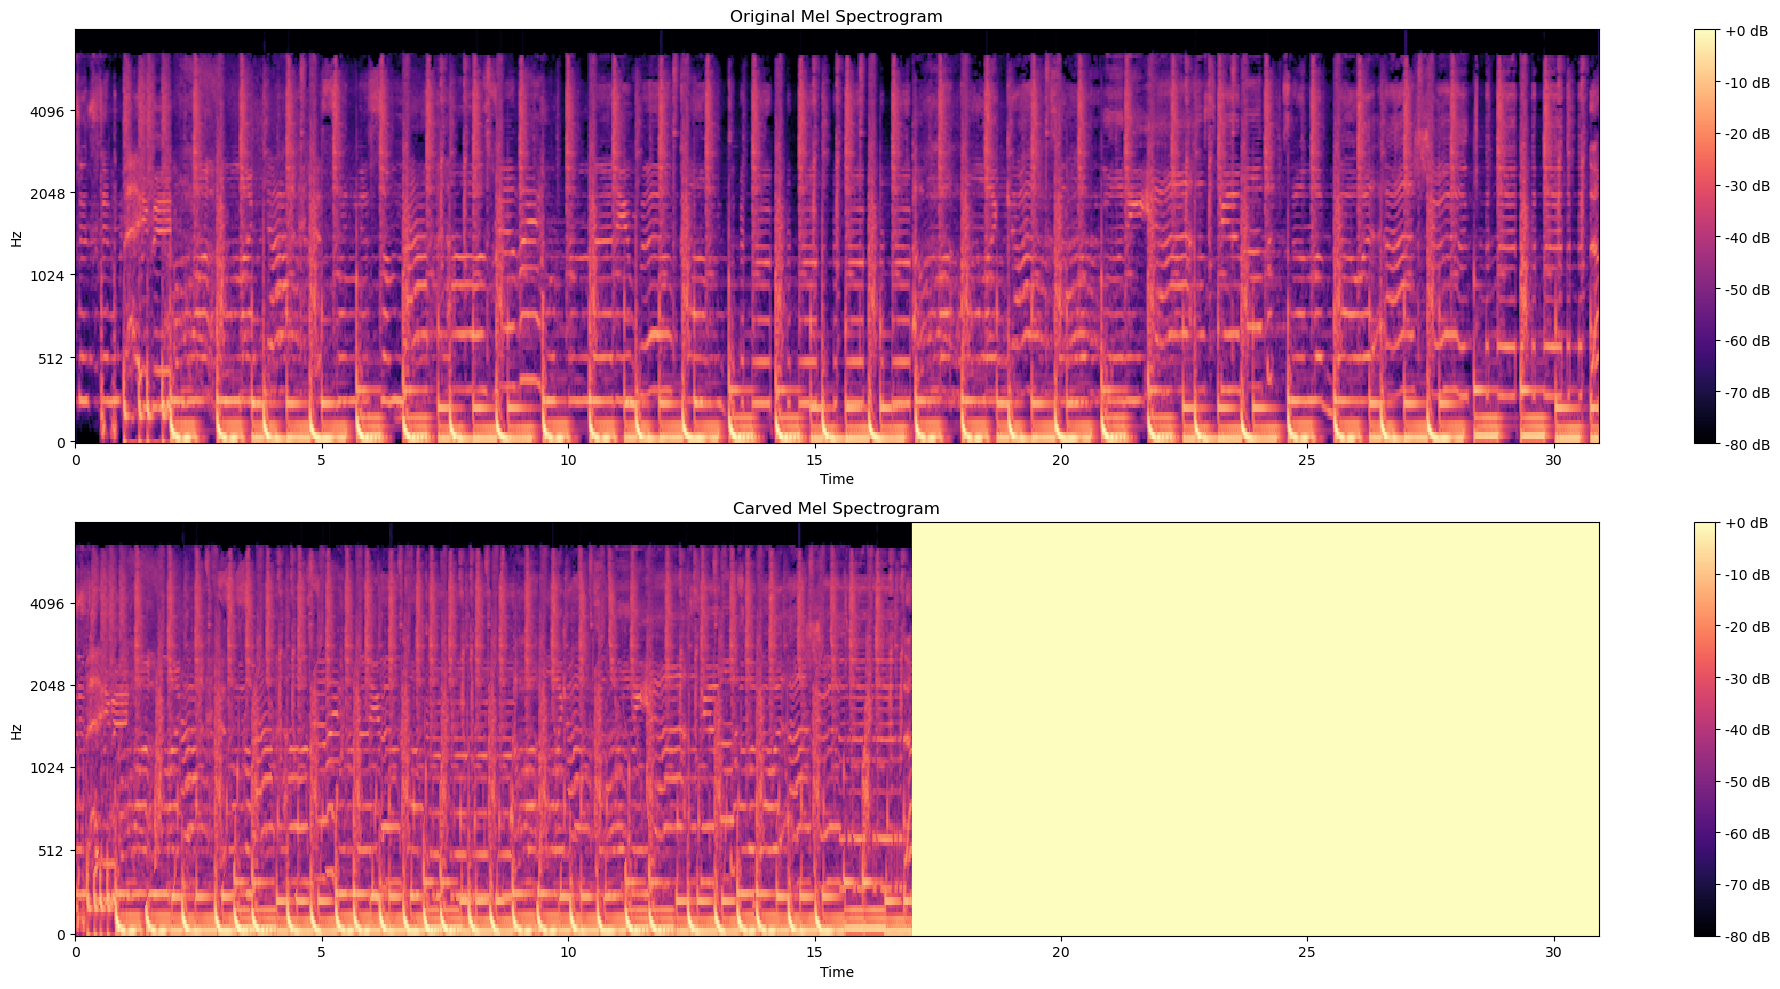

after (128, 1332)
The time of execution of above program is : 77372.6761341095 ms


In [34]:
# Extract dimensions
height, width = NJSpec.shape
print(f"Height (number of Mel bands): {height}")
print(f"Width (number of time frames): {width}")

# Carve seams from the Mel spectrogram
n_of_seams = 600  # Number of seams to remove
start = time.time()
carved_mel_spectrogram_db = carve_audio(n_of_seams, NJSpec, is_vertical=True)
end = time.time()
# Plot the original and carved Mel spectrograms
plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
librosa.display.specshow(NJSpec, y_axis='mel', fmax=8000, x_axis='time', cmap='magma')
plt.title('Original Mel Spectrogram')
plt.colorbar(format='%+2.0f dB')

plt.subplot(2, 1, 2)
librosa.display.specshow(carved_mel_spectrogram_db, y_axis='mel', fmax=8000, x_axis='time', cmap='magma')
plt.title('Carved Mel Spectrogram')
plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.show()
print("after", carved_mel_spectrogram_db.shape)
print("The time of execution of above program is :",
      (end-start) * 10**3, "ms")

In [35]:
import numpy as np

# Define the matrix
matrix = np.array([
    [1, 2, 3, 2, 3],
    [2, 1, 2, 3, 4],
    [3, 1, 3, 4, 5],
    [2, 3, 1, 3, 5],
    [2, 1, 2, 4, 3]
])

def non_cumulative_selection(matrix):
    rows, cols = matrix.shape
    index_map = np.zeros((rows, cols), dtype=int)
    
    for r in range(rows - 1):
        for c in range(cols):
            if c == 0:
                min_index = np.argmin(matrix[r+1, c:c+2]) + c
            elif c == cols - 1:
                min_index = np.argmin(matrix[r+1, c-1:c+1]) + c - 1
            else:
                min_index = np.argmin(matrix[r+1, c-1:c+2]) + c - 1
            index_map[r, c] = min_index
    
    # The last row's indices point to themselves
    index_map[-1, :] = np.arange(cols)
    
    return index_map

def calculate_seam_energy(matrix, index_map):
    rows, cols = matrix.shape
    sum_map = matrix.copy()
    offset_map = index_map.copy()
    
    step = 1
    while step < rows:
        for r in range(0, rows - step, step * 2):
            for c in range(cols):
                current_offset = offset_map[r, c]
                next_offset = offset_map[r + step, current_offset]
                sum_map[r, c] += sum_map[r + step, current_offset]
                offset_map[r, c] = next_offset
        step *= 2
    
    return sum_map[0, :]

def find_multiple_seams(matrix, num_seams):
    index_map = non_cumulative_selection(matrix)
    seam_energy = calculate_seam_energy(matrix, index_map)
    
    # Find the indices of the lowest energy seams
    seam_indices = np.argsort(seam_energy)[:num_seams]
    seams = []
    
    for seam_index in seam_indices:
        seam = []
        col = seam_index
        for row in range(matrix.shape[0]):
            seam.append((row, col))
            col = index_map[row, col]
        seams.append(seam)
    
    return seams

def remove_seams(matrix, seams):
    rows, cols = matrix.shape
    mask = np.ones((rows, cols), dtype=bool)
    
    for seam in seams:
        for (row, col) in seam:
            mask[row, col] = False
    
    new_matrix = matrix[mask].reshape(rows, cols - len(seams))
    return new_matrix

# Find and remove 2 seams
num_seams_to_remove = 2
seams = find_multiple_seams(matrix, num_seams_to_remove)
new_matrix = remove_seams(matrix, seams)

print("Original Matrix:")
print(matrix)
print("\nSeams to Remove:")
for seam in seams:
    print(seam)
print("\nNew Matrix after Removing Seams:")
print(new_matrix)


ValueError: cannot reshape array of size 19 into shape (5,3)